DICE Right Ventricle: 0.00624
DICE Myocardium: 0.03423
DICE Left Ventricle: 0.00001


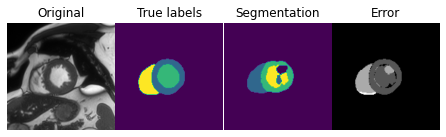

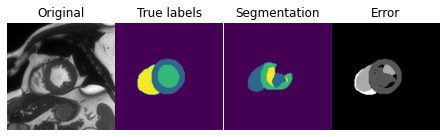

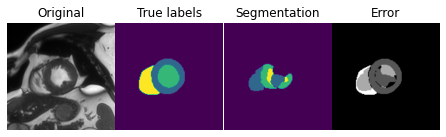

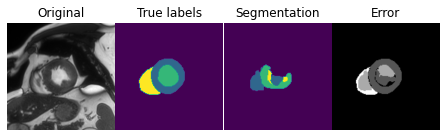

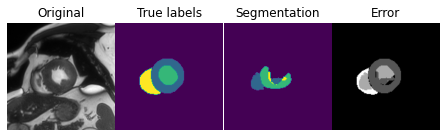

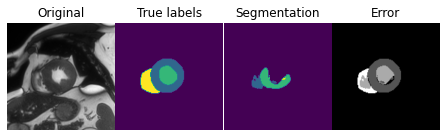

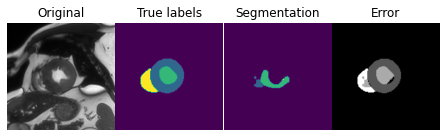

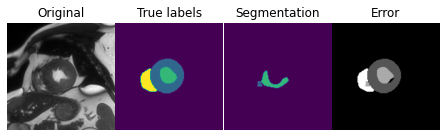

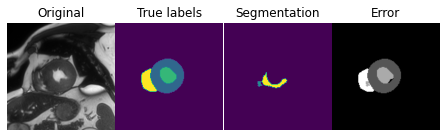

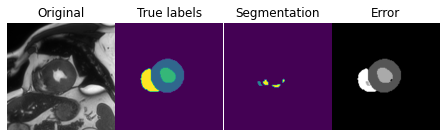

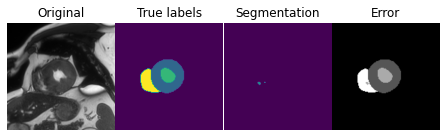

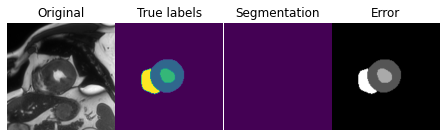

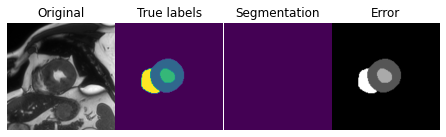

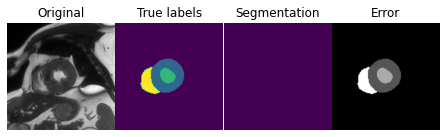

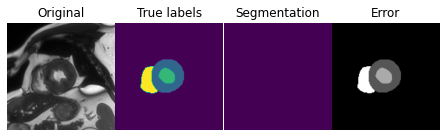

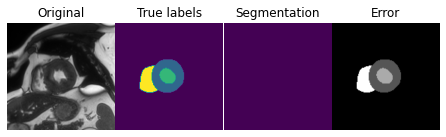

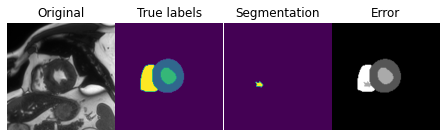

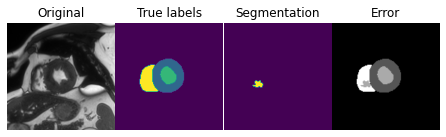

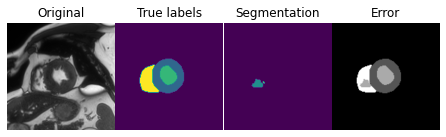

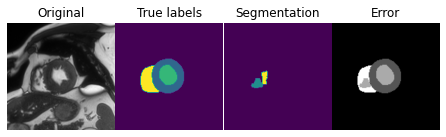

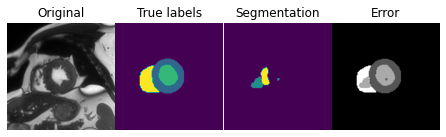

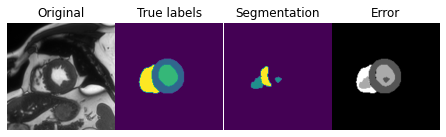

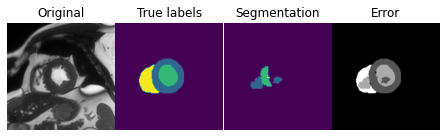

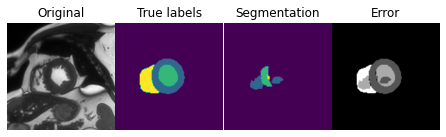

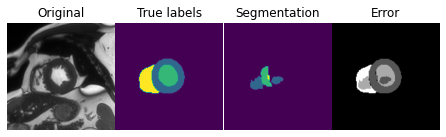

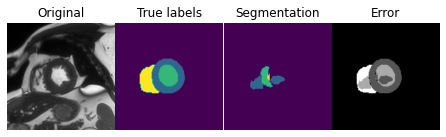

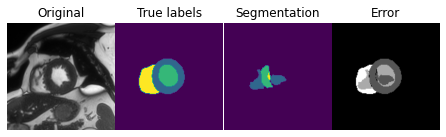

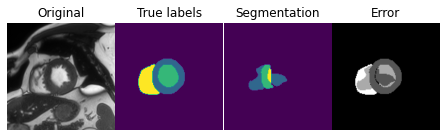

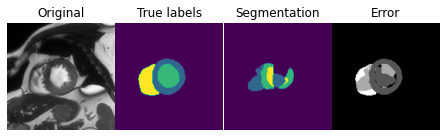

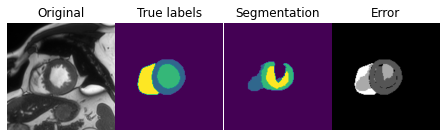

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  4 14:26:28 2020

@author: apramanik
"""

from torch.utils.data import DataLoader
import numpy as np
import os, torch
import matplotlib.pyplot as plt

from tst_dataset import cardiacdata
#from Auto3D_D4 import Auto3D as NN_MODEL
from UNET3D_D4 import UNet3D as NN_MODEL

%matplotlib inline

def dice_comp(pred, gt):
    return (2. * (np.sum(pred.astype(float) * gt.astype(float))) + 1.) / (np.sum(pred.astype(float)) \
        + np.sum(gt.astype(float)) + 1.)



#%%
nImg=1
dispind=1
vol_slice=4
chunk_size=nImg


MDL_PATH=r"/home/jovyan/project_segmentation_models/20"
#IMG_PATH = r"/home/jovyan/P2-Cardiac-Motion/NN_segmentation/datasets/patient005/patient005_4d.nii.gz"
IMG_PATH = r"/home/jovyan/P2-Cardiac-Motion/NN_segmentation/Datasets/patient021/image.nii.gz"
LBL_PATH = r"/home/jovyan/P2-Cardiac-Motion/NN_segmentation/Datasets/patient021/label.nii.gz"


#%%
tst_dataset = cardiacdata(IMG_PATH, LBL_PATH)
tst_loader = DataLoader(tst_dataset, batch_size=1, shuffle=False, num_workers=0)
# network
#net = NN_MODEL(num_classes=4, in_channels=1, depth=4, start_filts=32, res=False).cuda()
net = NN_MODEL(num_classes=4, depth=4, start_filts=32, in_channels=1, res=True).cuda()

net.load_state_dict(torch.load(os.path.join(MDL_PATH, "model_best.pth.tar"))['state_dict'])
img_shape = tst_dataset.img.shape
normOrg=np.zeros((1,img_shape[1],img_shape[2],img_shape[3]),dtype=np.float32)
normGT=np.zeros((1,img_shape[1],img_shape[2],img_shape[3]),dtype=np.int16)
normSeg=np.zeros((1,img_shape[1],img_shape[2],img_shape[3]),dtype=np.int16)
dice = np.zeros((nImg, 3))
net.eval()
for step, (img, seg_gt) in enumerate(tst_loader, 0):
    img, seg_gt = img.cuda(), seg_gt.cuda()
    pred = net(img)
    _, pred = torch.max(pred, 1)
    #pred, _ = torch.max(pred, 1)
    
    pred = pred.squeeze().detach().cpu().numpy().astype(np.int8)
    img = img.squeeze().detach().cpu().numpy()
    gt = seg_gt.squeeze().detach().cpu().numpy().astype(np.int8)
    for i in range(3):
        dice[step, i] = dice_comp(pred==i+1, gt==i+1)
    normOrg[step]=img
    normGT[step]=gt
    normSeg[step]=pred


    
print("DICE Right Ventricle: {0:.5f}".format(np.mean(dice[:,0])))
print("DICE Myocardium: {0:.5f}".format(np.mean(dice[:,1])))
print("DICE Left Ventricle: {0:.5f}".format(np.mean(dice[:,2])))



#%%%
normOrg=np.reshape(normOrg,[int(normOrg.shape[1]/8),8,144,144])
normGT=np.reshape(normGT,[int(normGT.shape[1]/8),8,144,144])
normSeg=np.reshape(normSeg,[int(normSeg.shape[1]/8),8,144,144])
normError=np.abs(normGT.astype(np.float32)-normSeg.astype(np.float32))
normOrg=normOrg-normOrg.min()

#%% Display the output images
for dispind in range(normOrg.shape[0]):
    plot= lambda x: plt.imshow(x,cmap=plt.cm.gray,interpolation='bilinear')
    plot1= lambda x: plt.imshow(x,interpolation='bilinear')
    plt.clf()
    plt.subplot(141)
    plot(np.abs(normOrg[dispind,vol_slice,:,:]))
    plt.axis('off')
    plt.title('Original')
    plt.subplot(142)
    plot1(np.abs(normGT[dispind,vol_slice,:,:]))
    plt.axis('off')
    plt.title('True labels')
    plt.subplot(143)
    plot1(np.abs(normSeg[dispind,vol_slice,:,:]))
    plt.axis('off')
    plt.title('Segmentation')
    plt.subplot(144)
    plot(np.abs(normError[dispind,vol_slice,:,:]))
    plt.title('Error')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=.01)
    plt.show()
# purple=0, blue=1, green=2, yellow=3